In [1]:
!pip install category_encoders

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


imports

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
from scipy import interp

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline,Pipeline,FeatureUnion
import category_encoders
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_curve, auc

from itertools import cycle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold,RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD

import glob

%matplotlib inline

In [4]:
source_dir = "dataset/train/"
filname_subs_features = "subs_features_train.csv"
filname_y = "subs_csi_train.csv"

target = "SK_ID"
seed = 33

Считаем train-файлы.

In [5]:
#dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%y')

df_sfeatures = pd.read_csv(source_dir + filname_subs_features, 
                             header=0, sep = ';', decimal=",",
                           parse_dates=['SNAP_DATE'])
df_y = pd.read_csv(source_dir + filname_y, 
                             header=0, sep = ';', decimal=",")

In [6]:
df_union = pd.merge(df_sfeatures, df_y, on=['SK_ID'])

In [7]:
df_union.shape

(47411, 38)

In [8]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47411 entries, 0 to 47410
Data columns (total 38 columns):
SNAP_DATE           47411 non-null datetime64[ns]
COM_CAT#1           47411 non-null int64
SK_ID               47411 non-null int64
COM_CAT#2           47411 non-null int64
COM_CAT#3           47411 non-null int64
BASE_TYPE           47411 non-null int64
ACT                 47411 non-null int64
ARPU_GROUP          47390 non-null float64
COM_CAT#7           47411 non-null int64
COM_CAT#8           47287 non-null float64
DEVICE_TYPE_ID      47300 non-null float64
INTERNET_TYPE_ID    47300 non-null float64
REVENUE             47411 non-null float64
ITC                 47411 non-null float64
VAS                 47411 non-null float64
RENT_CHANNEL        47411 non-null float64
ROAM                47411 non-null float64
COST                47411 non-null float64
COM_CAT#17          47411 non-null float64
COM_CAT#18          47411 non-null float64
COM_CAT#19          47411 non-null flo

In [9]:
# set option to view more columns as by default
pd.set_option('display.max_columns', df_sfeatures.shape[1])

In [10]:
df_union.columns = df_union.columns.str.replace("[#]", "_")

In [11]:
df_union.head()

,SNAP_DATE,COM_CAT_1,SK_ID,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,...,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,CSI,CONTACT_DATE
0,2001-01-08,4,3339,80,5,2,1,12.0,1,1489.0,5.0,2.0,0.153024,0.081527,0.104168,0.058596,0.0,0.014106,...,0.026212,0.706638,0.019298,0.706638,0.147071,31.12,1,1,0.031696,0.076724,0.040279,0.013300,0.083382,0.027579,0.103896,2.0,1,13.05
1,2002-01-01,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.150506,0.048746,0.090899,0.056983,0.0,0.009771,...,0.026212,0.709107,0.019298,0.709107,0.139332,31.12,1,1,0.055658,0.048290,0.026180,0.014695,0.073732,0.027579,0.103896,2.0,1,13.05
2,2001-01-06,4,3339,80,5,2,1,12.0,1,1489.0,5.0,2.0,0.143226,0.022492,0.084648,0.056036,0.0,0.006612,...,0.026212,0.708986,0.019298,0.708986,0.138648,31.12,1,1,0.026727,0.022298,0.011269,0.000004,0.163625,0.027579,0.103896,2.0,1,13.05
3,2001-01-12,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.152471,0.087388,0.088690,0.058714,0.0,0.013697,...,0.026212,0.706760,0.019298,0.706760,0.136914,31.12,1,1,0.073945,0.086367,0.032632,0.017697,0.107121,0.027579,0.103896,2.0,1,13.05
4,2001-01-10,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.142156,0.033726,0.089917,0.059585,0.0,0.008382,...,0.026212,0.707238,0.019298,0.707238,0.135508,31.12,1,1,0.035139,0.033726,0.030531,0.053506,0.114678,0.027579,0.103896,2.0,1,13.05


In [12]:
df_union.tail()

,SNAP_DATE,COM_CAT_1,SK_ID,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,...,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,CSI,CONTACT_DATE
47406,2002-01-04,2,820,72,17,1,1,10.0,2,1311.0,5.0,2.0,0.135500,0.084692,0.096958,0.070279,0.0,0.014877,...,0.026212,0.699861,0.019298,0.699861,0.131095,31.12,1,0,0.022032,0.084617,0.013335,0.093011,0.066415,0.027579,0.103896,NaN,0,08.05
47407,2002-01-05,2,820,72,9,1,1,11.0,2,1311.0,5.0,2.0,0.137304,0.065791,0.085346,0.066448,0.0,0.011888,...,0.026212,0.702812,0.019298,0.702812,0.126186,31.12,1,1,0.050142,0.065791,0.009687,0.072731,0.070489,0.027713,0.103930,NaN,0,08.05
47408,2002-01-04,2,350,72,17,1,1,5.0,2,847.0,5.0,2.0,0.112518,0.000311,0.084167,0.055425,0.0,0.004274,...,0.057468,0.699969,0.047798,0.698135,0.113969,31.12,1,0,0.000000,0.000311,0.000419,0.002828,0.000140,0.027579,0.103896,NaN,0,30.05
47409,2002-01-05,2,350,72,9,1,1,10.0,2,847.0,5.0,2.0,0.133845,0.094739,0.084167,0.056897,0.0,0.014005,...,0.026212,0.699953,0.021944,0.698553,0.132574,31.12,1,1,0.006226,0.027330,0.001351,0.011215,0.057732,0.027579,0.103896,NaN,0,30.05
47410,2002-01-05,2,1426,72,17,1,1,6.0,2,1577.0,5.0,1.0,0.119369,0.036923,0.084698,0.056909,0.0,0.008154,...,0.063121,0.699380,0.048089,0.697214,0.119834,31.12,1,0,0.004389,0.036923,0.010831,0.000000,0.027432,0.027579,0.103896,NaN,0,29.05


In [13]:
df_union.describe()

,COM_CAT_1,SK_ID,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,CSI
count,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47390.000000,47411.000000,47287.000000,47300.000000,47300.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,47411.000000,45808.000000,47411.000000
mean,4.538019,2346.231107,41.213642,5.267280,1.938706,0.990909,7.672800,2.378119,866.040793,4.619831,1.902304,0.129258,0.019094,0.087581,0.057320,0.000058,0.006618,0.003416,0.003391,0.026656,0.704057,0.019758,0.703902,0.126594,0.999852,0.988420,0.017048,0.018507,0.004788,0.005083,0.046062,0.028243,0.104881,5.536587,0.156694
std,2.175724,1365.543733,22.381202,2.757143,0.239871,0.094912,3.179402,1.587738,516.196163,0.883446,0.720701,0.021383,0.032490,0.012187,0.013827,0.004763,0.006034,0.021606,0.025057,0.012408,0.006803,0.003463,0.006832,0.018696,0.012150,0.106985,0.025277,0.031138,0.017611,0.021956,0.051001,0.009148,0.007879,3.554345,0.363515
min,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.059879,0.000000,0.000000,0.000534,0.000000,0.000000,0.000000,0.000000,0.004464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,1160.000000,25.000000,5.000000,2.000000,1.000000,5.000000,1.000000,388.000000,5.000000,1.000000,0.116032,0.001163,0.084167,0.054999,0.000000,0.004452,0.000000,0.000000,0.026212,0.700520,0.019298,0.700340,0.115673,1.000000,1.000000,0.002169,0.001073,0.000000,0.000000,0.011571,0.027579,0.103896,2.000000,0.000000
50%,4.000000,2345.000000,38.000000,5.000000,2.000000,1.000000,8.000000,2.000000,924.000000,5.000000,2.000000,0.124921,0.007509,0.084228,0.055171,0.000000,0.005285,0.000000,0.000000,0.026212,0.702909,0.019298,0.702774,0.122772,1.000000,1.000000,0.008714,0.007226,0.000120,0.000000,0.031394,0.027579,0.103896,4.000000,0.000000
75%,6.000000,3543.000000,60.000000,5.000000,2.000000,1.000000,10.000000,3.000000,1318.000000,5.000000,2.000000,0.136216,0.023484,0.086645,0.056143,0.000000,0.007203,0.000000,0.000000,0.026212,0.705931,0.019298,0.705808,0.131808,1.000000,1.000000,0.022257,0.022745,0.003028,0.000383,0.063415,0.027579,0.103896,9.000000,0.000000
max,8.000000,4702.000000,83.000000,17.000000,2.000000,1.000000,12.000000,9.000000,1702.000000,8.000000,3.000000,1.000000,0.745436,0.885316,0.962480,1.000000,1.000000,1.000000,0.625064,1.000000,1.000000,0.133828,1.000000,1.000000,1.000000,1.000000,1.000000,0.645294,1.000000,1.000000,1.000000,0.560674,0.377696,10.000000,1.000000


Missing values

In [14]:
print (pd.concat([1- df_union.count() / df_union.shape[0], df_union.isna().sum()],axis=1))

                         0     1
SNAP_DATE         0.000000     0
COM_CAT_1         0.000000     0
SK_ID             0.000000     0
COM_CAT_2         0.000000     0
COM_CAT_3         0.000000     0
BASE_TYPE         0.000000     0
ACT               0.000000     0
ARPU_GROUP        0.000443    21
COM_CAT_7         0.000000     0
COM_CAT_8         0.002615   124
DEVICE_TYPE_ID    0.002341   111
INTERNET_TYPE_ID  0.002341   111
REVENUE           0.000000     0
ITC               0.000000     0
VAS               0.000000     0
RENT_CHANNEL      0.000000     0
ROAM              0.000000     0
COST              0.000000     0
COM_CAT_17        0.000000     0
COM_CAT_18        0.000000     0
COM_CAT_19        0.000000     0
COM_CAT_20        0.000000     0
COM_CAT_21        0.000000     0
COM_CAT_22        0.000000     0
COM_CAT_23        0.000000     0
COM_CAT_24        0.000000     0
COM_CAT_25        0.000000     0
COM_CAT_26        0.000000     0
COM_CAT_27        0.000000     0
COM_CAT_28

Duplicates by SK_ID

Гипотеза - возможно стоит группировать и брать средние за 12 месяцев!

In [15]:
df_union[df_union.SK_ID == 3339].sort_values('SNAP_DATE',ascending=False) #3608

,SNAP_DATE,COM_CAT_1,SK_ID,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,...,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,CSI,CONTACT_DATE
10,2002-01-05,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.152648,0.071165,0.088724,0.058856,0.0,0.012058,...,0.026212,0.708091,0.019298,0.708091,0.138358,31.12,1,1,0.068973,0.071165,0.060654,0.010096,0.109189,0.027579,0.103896,2.0,1,13.05
11,2002-01-04,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.146904,0.039467,0.090637,0.061338,0.0,0.009152,...,0.026212,0.708316,0.019298,0.708316,0.139378,31.12,1,1,0.037451,0.037747,0.065096,0.063092,0.092053,0.027579,0.103896,2.0,1,13.05
8,2002-01-03,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.153125,0.089727,0.086884,0.062059,0.0,0.014080,...,0.026212,0.706693,0.019298,0.706693,0.138393,31.12,1,1,0.069798,0.086321,0.045110,0.081978,0.107824,0.027579,0.103896,2.0,1,13.05
6,2002-01-02,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.144922,0.047471,0.090825,0.058738,0.0,0.009774,...,0.026212,0.707135,0.019298,0.707135,0.135779,31.12,1,1,0.046714,0.047219,0.033011,0.031543,0.062931,0.027579,0.103896,2.0,1,13.05
1,2002-01-01,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.150506,0.048746,0.090899,0.056983,0.0,0.009771,...,0.026212,0.709107,0.019298,0.709107,0.139332,31.12,1,1,0.055658,0.048290,0.026180,0.014695,0.073732,0.027579,0.103896,2.0,1,13.05
3,2001-01-12,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.152471,0.087388,0.088690,0.058714,0.0,0.013697,...,0.026212,0.706760,0.019298,0.706760,0.136914,31.12,1,1,0.073945,0.086367,0.032632,0.017697,0.107121,0.027579,0.103896,2.0,1,13.05
7,2001-01-11,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.162482,0.073122,0.095195,0.060743,0.0,0.012831,...,0.026212,0.710960,0.019298,0.710960,0.145504,31.12,1,1,0.080417,0.072672,0.058086,0.036068,0.134986,0.027579,0.103896,2.0,1,13.05
4,2001-01-10,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.142156,0.033726,0.089917,0.059585,0.0,0.008382,...,0.026212,0.707238,0.019298,0.707238,0.135508,31.12,1,1,0.035139,0.033726,0.030531,0.053506,0.114678,0.027579,0.103896,2.0,1,13.05
5,2001-01-09,4,3339,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.145285,0.050051,0.084167,0.059378,0.0,0.009651,...,0.026212,0.707359,0.019298,0.707359,0.134488,31.12,1,1,0.053856,0.050051,0.033896,0.042431,0.106840,0.027579,0.103896,2.0,1,13.05
0,2001-01-08,4,3339,80,5,2,1,12.0,1,1489.0,5.0,2.0,0.153024,0.081527,0.104168,0.058596,0.0,0.014106,...,0.026212,0.706638,0.019298,0.706638,0.147071,31.12,1,1,0.031696,0.076724,0.040279,0.013300,0.083382,0.027579,0.103896,2.0,1,13.05


In [25]:
df_union.SNAP_DATE.unique()

array(['2001-01-08T00:00:00.000000000', '2002-01-01T00:00:00.000000000',
       '2001-01-06T00:00:00.000000000', '2001-01-12T00:00:00.000000000',
       '2001-01-10T00:00:00.000000000', '2001-01-09T00:00:00.000000000',
       '2002-01-02T00:00:00.000000000', '2001-01-11T00:00:00.000000000',
       '2002-01-03T00:00:00.000000000', '2001-01-07T00:00:00.000000000',
       '2002-01-05T00:00:00.000000000', '2002-01-04T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [23]:
df_union.COM_CAT_24.unique()

array(['31.12', '27.05', '29.05', '06.05', '28.05', '23.05', '24.05',
       '30.05'], dtype=object)

In [24]:
df_union.CONTACT_DATE.unique()

array(['13.05', '31.05', '24.05', '28.05', '12.05', '06.05', '29.05',
       '30.05', '27.05', '02.05', '11.05', '19.05', '21.05', '14.05',
       '09.05', '05.05', '10.05', '22.05', '07.05', '03.05', '25.05',
       '01.05', '17.05', '20.05', '08.05', '04.05', '18.05', '15.05',
       '16.05', '26.05', '23.05'], dtype=object)

In [37]:
df_num_features = df_union.select_dtypes([np.number]).columns

In [38]:
df_cat_features = df_union.select_dtypes([np.object,'datetime']).columns

Numerical features analyse.

In [50]:
df_good = df_union[df_num_features][df_union.CSI == 0]
df_bad = df_union[df_num_features][df_union.CSI == 1]

In [56]:
df_good.describe()

,COM_CAT_1,SK_ID,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,CSI
count,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39965.000000,39982.000000,39888.000000,39893.000000,39893.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,39982.000000,38593.000000,39982.0
mean,4.531839,2344.331749,41.440398,5.274198,1.937122,0.991596,7.609308,2.370067,867.701339,4.611711,1.903692,0.128812,0.018607,0.087611,0.057006,0.000057,0.006545,0.003523,0.003397,0.026676,0.703956,0.019771,0.703796,0.126198,0.999875,0.988145,0.016850,0.017995,0.004878,0.005114,0.045365,0.028250,0.104809,5.563936,0.0
std,2.140678,1366.853611,22.351087,2.778118,0.242747,0.091287,3.177496,1.559236,514.847145,0.892517,0.727929,0.020797,0.032160,0.012583,0.009025,0.005111,0.006232,0.022381,0.024888,0.012554,0.006829,0.003532,0.006855,0.018065,0.011182,0.108236,0.025054,0.030577,0.018519,0.022183,0.050059,0.009570,0.007501,3.559028,0.0
min,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.059879,0.001785,0.000000,0.000534,0.000000,0.000000,0.000000,0.000000,0.004464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007143,0.090927,1.000000,0.0
25%,3.000000,1165.250000,25.000000,5.000000,2.000000,1.000000,5.000000,1.000000,391.000000,5.000000,1.000000,0.115810,0.001102,0.084167,0.054998,0.000000,0.004443,0.000000,0.000000,0.026212,0.700460,0.019298,0.700276,0.115371,1.000000,1.000000,0.002106,0.001018,0.000000,0.000000,0.011417,0.027579,0.103896,2.000000,0.0
50%,4.000000,2337.000000,39.000000,5.000000,2.000000,1.000000,8.000000,2.000000,923.000000,5.000000,2.000000,0.124645,0.007194,0.084239,0.055152,0.000000,0.005253,0.000000,0.000000,0.026212,0.702843,0.019298,0.702703,0.122532,1.000000,1.000000,0.008605,0.006919,0.000086,0.000000,0.030713,0.027579,0.103896,4.000000,0.0
75%,6.000000,3537.750000,60.000000,5.000000,2.000000,1.000000,10.000000,3.000000,1318.000000,5.000000,2.000000,0.135723,0.022730,0.086669,0.056092,0.000000,0.007097,0.000000,0.000000,0.026212,0.705802,0.019298,0.705676,0.131389,1.000000,1.000000,0.021979,0.022087,0.002893,0.000299,0.062429,0.027579,0.103896,9.000000,0.0
max,8.000000,4702.000000,83.000000,17.000000,2.000000,1.000000,12.000000,9.000000,1702.000000,8.000000,3.000000,1.000000,0.745436,0.885316,0.768022,1.000000,1.000000,1.000000,0.625064,1.000000,1.000000,0.133828,1.000000,1.000000,1.000000,1.000000,1.000000,0.645294,1.000000,1.000000,0.730168,0.560674,0.377696,10.000000,0.0


In [55]:
df_bad.describe()

,COM_CAT_1,SK_ID,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,CSI
count,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7425.000000,7429.000000,7399.000000,7407.000000,7407.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000,7215.000000,7429.0
mean,4.571275,2356.453224,39.993270,5.230044,1.947234,0.987212,8.014545,2.421456,857.088796,4.663561,1.894829,0.131658,0.021715,0.087420,0.059008,0.000060,0.007009,0.002843,0.003363,0.026552,0.704600,0.019692,0.704472,0.128729,0.999731,0.989904,0.018109,0.021263,0.004303,0.004916,0.049813,0.028210,0.105270,5.390298,1.0
std,2.355275,1358.518445,22.504896,2.641266,0.223581,0.112365,3.168074,1.732572,523.353252,0.831593,0.680450,0.024159,0.034091,0.009781,0.027903,0.002041,0.004811,0.016829,0.025948,0.011593,0.006630,0.003064,0.006681,0.021653,0.016407,0.099975,0.026425,0.033869,0.011552,0.020696,0.055653,0.006418,0.009655,3.525835,0.0
min,1.000000,6.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.072962,0.000000,0.078794,0.000000,0.000000,0.001323,0.000000,0.000000,0.026212,0.582712,0.019298,0.582712,0.063800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,3.000000,1143.000000,24.000000,5.000000,2.000000,1.000000,6.000000,1.000000,350.000000,5.000000,1.000000,0.117352,0.001641,0.084167,0.055014,0.000000,0.004518,0.000000,0.000000,0.026212,0.700887,0.019298,0.700726,0.116816,1.000000,1.000000,0.002487,0.001473,0.000000,0.000000,0.012392,0.027579,0.103896,2.000000,1.0
50%,4.000000,2377.000000,35.000000,5.000000,2.000000,1.000000,8.000000,2.000000,925.000000,5.000000,2.000000,0.126664,0.009369,0.084167,0.055294,0.000000,0.005494,0.000000,0.000000,0.026212,0.703290,0.019298,0.703178,0.124028,1.000000,1.000000,0.009188,0.008970,0.000380,0.000000,0.035210,0.027579,0.103896,4.000000,1.0
75%,7.000000,3569.000000,59.000000,5.000000,2.000000,1.000000,11.000000,3.000000,1318.000000,5.000000,2.000000,0.138940,0.027928,0.086469,0.056411,0.000000,0.007726,0.000000,0.000000,0.026212,0.706597,0.019298,0.706488,0.134043,1.000000,1.000000,0.023881,0.027153,0.003784,0.000832,0.069000,0.027579,0.103896,9.000000,1.0
max,8.000000,4701.000000,83.000000,17.000000,2.000000,1.000000,12.000000,9.000000,1701.000000,8.000000,3.000000,0.625346,0.610437,0.232942,0.962480,0.156796,0.161956,0.402752,0.445733,0.977035,0.841708,0.124721,0.841708,0.617397,1.000000,1.000000,0.608438,0.610437,0.245789,0.555927,1.000000,0.303090,0.263390,10.000000,1.0


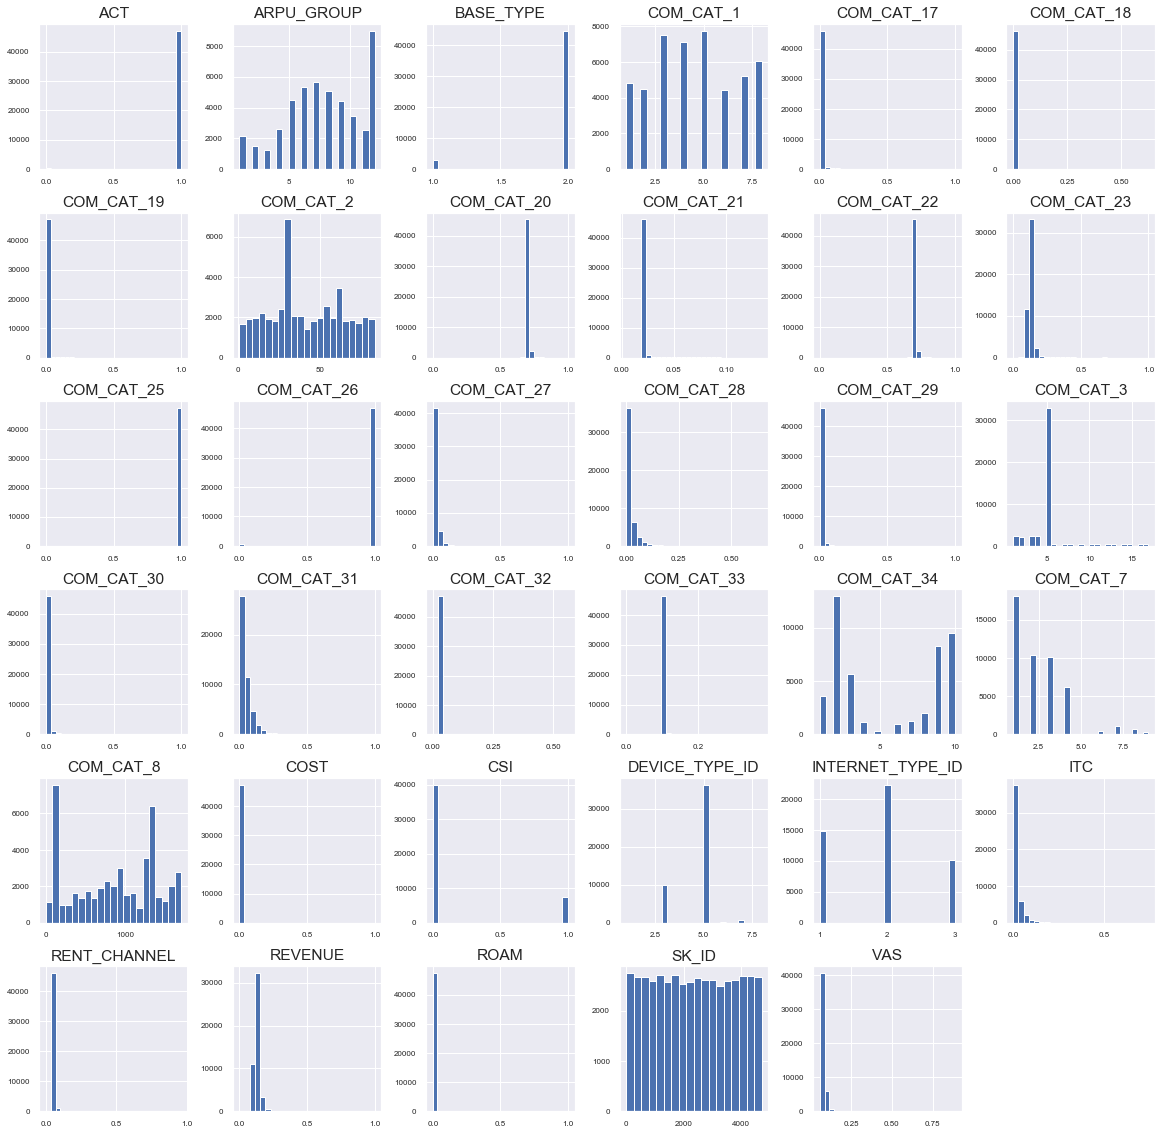

In [41]:
df_union[df_num_features].hist(figsize=(20, 20), bins='doane', xlabelsize=8, ylabelsize=8);

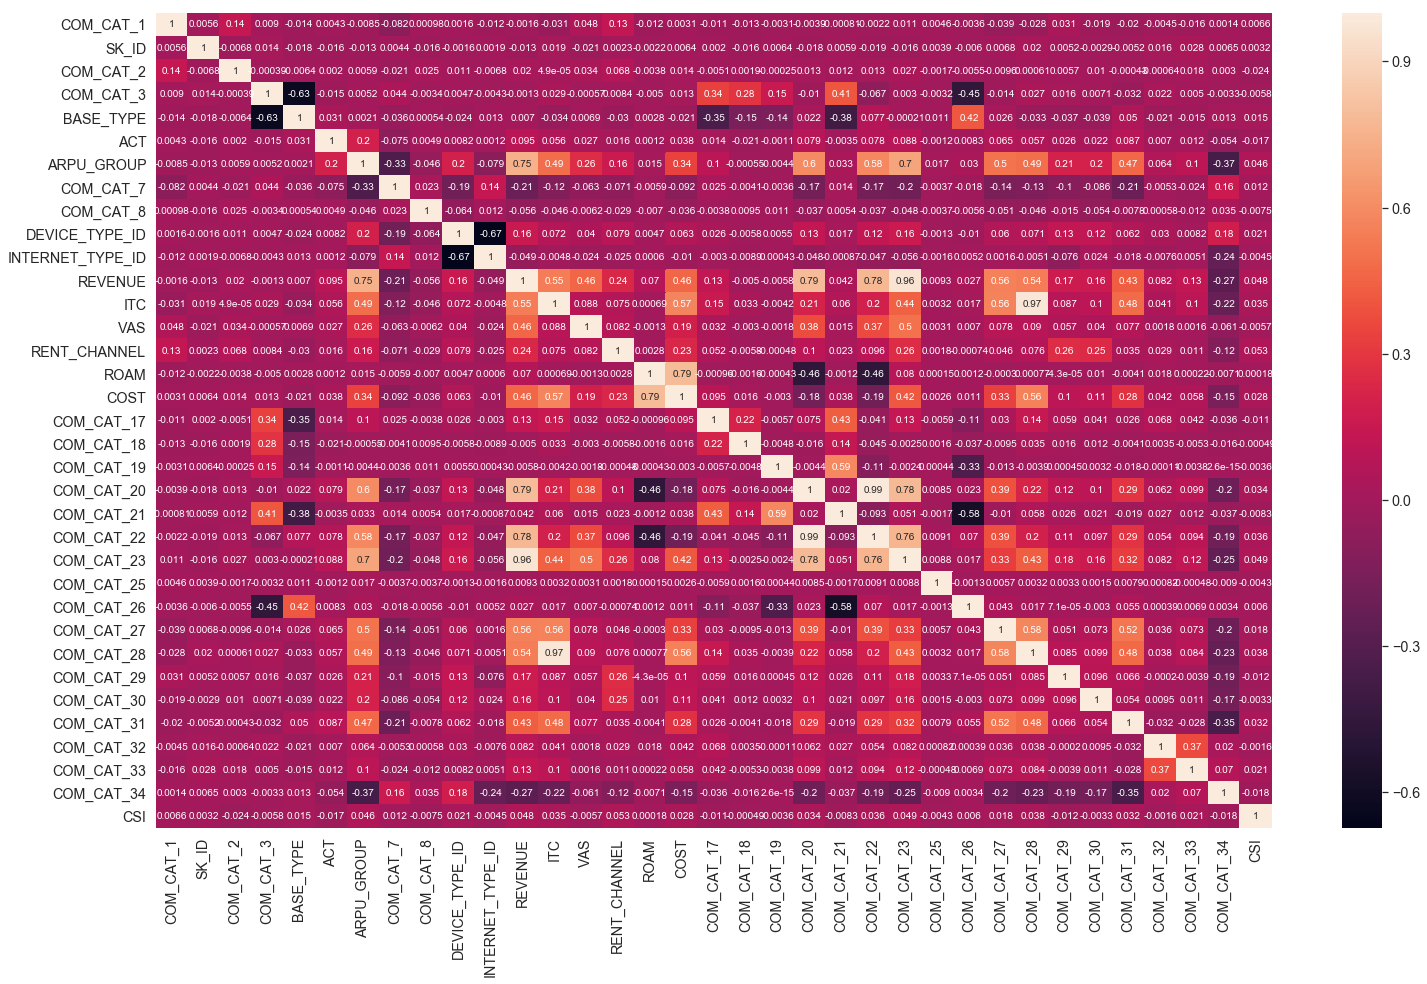

In [60]:
plt.figure(figsize=(25, 15))
corr = df_union[df_num_features].corr()
sns.heatmap(corr, annot=True);

In [ ]:
for file_ in allFiles:
    df = pd.read_csv(file_,index_col='SK_ID', header=0, sep = ';',error_bad_lines=False)
    list_.append(df)


In [ ]:
frame = pd.concat(list_, axis = 0, ignore_index = True)

In [ ]:
frame.SK_ID